之前提到的分类问题实际上只能处理单分类，或者叫二分类，即输出的结果只有两种情况，要么是要么不是，但是考虑MNIST数据集，![](https://pic.imgdb.cn/item/659cdc5e871b83018a333a78.jpg) ，此时输出的数字有0～9共10种结果，那么就不能按照之前的方法做。

不妨先考虑如果按照之前的做法，我们考虑一个输出，成功为1，所有其他输出考虑为0，也能转换，即![](https://pic.imgdb.cn/item/659cdd45871b83018a36383d.jpg)，但是问题在于，这样可能会出现 $P\{\hat{y}=1\}=0.9,P\{\hat{y}=2\}=0.8$ 的情况，但是我们希望最终预测的是一个数，即对于一个样本，不同预测之间是竞争关系，一个大，另一个就相应的小。因此，我们希望每一个样本的输出是一个分布，即满足：$\begin{aligned}P(y=i)&\geq0\\\sum_{i=0}^9P(y=i)&=1\end{aligned}$ ，因此最后一层线性层后我们不再进入sigmoid层，而是进入softmax层，![](https://pic.imgdb.cn/item/659cdf24871b83018a3d40aa.png) ，softmax层做的是 $P(y=i)=\frac{e^{z_i}}{\sum_{j=0}^{K-1}e^{z_j}},i\in\{0,...,K-1\}$ ，能够确保输出的是一个分布。

考虑loss函数时，Y实际上是One-Hot编码，例如最终Y是2，则label为[0, 0, 1]。这样对于交叉熵而言，起作用的只有一项，![](https://pic.imgdb.cn/item/659cdfad871b83018a3f0767.jpg)  
torch 中把右边的过程整合起来叫做 NLLLoss，![](https://pic.imgdb.cn/item/659ce04e871b83018a410cc9.jpg)  
而把从softmax层一直到损失计算叫做 CrossEntropyLoss，![](https://pic.imgdb.cn/item/659ce0b2871b83018a4249b7.jpg)

针对MNIST数据集，实际上每一张图片是一个28*28的矩阵，表示其RGB值，要把图片转化为Tensor，就需要用到`torchvision.transforms` ：  
```py
transform = transforms.Compose([
    transforms.toTensor()
    transforms.Normalize((0.1307,), (0.3081,))
])
```  
这里`toTensor` 的作用是 ![](https://pic.imgdb.cn/item/659ce239871b83018a471425.jpg) ，平时我们图像存储一般是宽*高*通道，而在torch中通常采用通道*宽*高，因此需要`toTensor`，下面的`Normalize`则是归一化，第一个参数为均值，第二个参数为标准差，使数据满足标准正态分布，更容易计算![](https://pic.imgdb.cn/item/659ce300871b83018a497d7a.jpg)

整个模型为![](https://pic.imgdb.cn/item/659ce3a7871b83018a4b96c5.jpg)  
首先要让一个28*28的样本变为一行，这样整个样本就变为N*784的矩阵，每一行就是一个样本，最终通过线性变化成N*10的矩阵，再进过softmax层，这样每一列的数值就是概率，只需要取概率最大的位置，就是原始样本图片的预测数字，

In [38]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np

batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

train_dataset = datasets.MNIST(root='./dataset/mnist/',
                               train=True,
                               download=True,
                               transform=transform)

train_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=batch_size,
                          )

test_dataset = datasets.MNIST(root='./dataset/mnist/',
                              train=False,
                              download=True,
                              transform=transform)

test_loader = DataLoader(dataset=test_dataset,
                         shuffle=False,         # 测试集可以不打乱，因为有时候需要人工检查
                         batch_size=batch_size)

In [39]:
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(784, 512)
        self.l2 = torch.nn.Linear(512, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 64)
        self.l5 = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)             # x本来是[N,1,28,28]的矩阵，但是经过view变[N,784]
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)               # 最后一层不用经过激活层relu，因为loss函数中自带了softmax

model = Net()

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.5)

In [41]:
def train(epoch):
    running_loss = 0.0
    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        y_pred = model(inputs)
        loss = criterion(y_pred, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
    return running_loss / idx 

In [42]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, pred = torch.max(outputs.data, dim=1)        # max返回两个参数：最大值以及其下标，dim=1规定列视角
            total += labels.size(0)                         # label.size 返回[64, 1]
            correct += (pred == labels).sum().item()
    return correct / total

In [43]:
if __name__ == '__main__':
    loss_list = []
    test_list = []
    for epoch in range(100):
        loss_list.append(train(epoch))
        test_list.append(test())


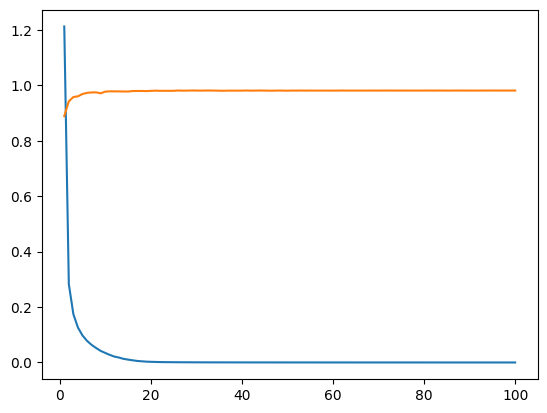

In [44]:
import matplotlib.pyplot as plt
xx = np.arange(1, len(loss_list) + 1, 1)
plt.plot(xx, loss_list)
plt.plot(xx, test_list)
plt.show()

In [ ]:
# 这是改了一点的训练过程，不输出loss，而是定期输出测试集上的效果
def train():
    for idx, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, data in enumerate(test_dataloader, 0):
            inputs, labels = data

            outputs = model(inputs)
            _, pred = torch.max(outputs.data, dim=1)
            correct += (pred == labels).sum().item()
            total += pred.size(0)
        print("correct acc is %lf" % (correct / total))

if __name__ == '__main__':
    for epoch in range(100):
        train()
    if epoch % 10 == 9:
        test()